# Network Intrusion Detection using Random Forest

## Objective
Build a Random Forest model to detect network intrusions using the KDDCUP'99 dataset.

### Problems to Solve:
1. **Binary Classification**: Normal vs Attack
2. **Multi-class Classification**: Normal vs DOS vs PROBE vs R2L vs U2R


## 1. Import Required Libraries


In [2]:
# Data manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import (
    classification_report, 
    confusion_matrix, 
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    roc_curve
)

# Model persistence
import pickle
import joblib

# Warnings
import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

# Set plot style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

print("Libraries imported successfully!")


Libraries imported successfully!


## 2. Load Dataset


In [3]:
# Define column names
columns = [
    "duration", "protocol_type", "service", "flag", "src_bytes", "dst_bytes", "land",
    "wrong_fragment", "urgent", "hot", "num_failed_logins", "logged_in",
    "num_compromised", "root_shell", "su_attempted", "num_root", "num_file_creations",
    "num_shells", "num_access_files", "num_outbound_cmds", "is_host_login",
    "is_guest_login", "count", "srv_count", "serror_rate", "srv_serror_rate",
    "rerror_rate", "srv_rerror_rate", "same_srv_rate", "diff_srv_rate",
    "srv_diff_host_rate", "dst_host_count", "dst_host_srv_count",
    "dst_host_same_srv_rate", "dst_host_diff_srv_rate", "dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate", "dst_host_serror_rate", "dst_host_srv_serror_rate",
    "dst_host_rerror_rate", "dst_host_srv_rerror_rate", "attack", "last_flag"
]

# Load training data
print("Loading training data...")
df_train = pd.read_csv(
    "archive/Train.txt",
    sep=",",
    names=columns,
    header=None
)

# Load test data
print("Loading test data...")
df_test = pd.read_csv(
    "archive/Test.txt",
    sep=",",
    names=columns,
    header=None
)

print(f"Training data shape: {df_train.shape}")
print(f"Test data shape: {df_test.shape}")

df_train.head()


Loading training data...
Loading test data...
Training data shape: (125973, 43)
Test data shape: (22544, 43)


,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack,last_flag
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,0.0,0.0,0.0,0.0,1.00,0.00,0.00,150,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal,20
1,0,udp,other,SF,146,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13,1,0.0,0.0,0.0,0.0,0.08,0.15,0.00,255,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal,15
2,0,tcp,private,S0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,123,6,1.0,1.0,0.0,0.0,0.05,0.07,0.00,255,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,19
3,0,tcp,http,SF,232,8153,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,5,5,0.2,0.2,0.0,0.0,1.00,0.00,0.00,30,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal,21
4,0,tcp,http,SF,199,420,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,30,32,0.0,0.0,0.0,0.0,1.00,0.00,0.09,255,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal,21


## 3. Exploratory Data Analysis (EDA)


In [4]:
# Basic information
print("Dataset Info:")
print(df_train.info())
print("\nDataset shape:", df_train.shape)
print("\nMissing values:", df_train.isnull().sum().sum())


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125973 entries, 0 to 125972
Data columns (total 43 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   duration                     125973 non-null  int64  
 1   protocol_type                125973 non-null  object 
 2   service                      125973 non-null  object 
 3   flag                         125973 non-null  object 
 4   src_bytes                    125973 non-null  int64  
 5   dst_bytes                    125973 non-null  int64  
 6   land                         125973 non-null  int64  
 7   wrong_fragment               125973 non-null  int64  
 8   urgent                       125973 non-null  int64  
 9   hot                          125973 non-null  int64  
 10  num_failed_logins            125973 non-null  int64  
 11  logged_in                    125973 non-null  int64  
 12  num_compromised              125973 non-null

In [5]:
# Check unique attack types
print("Unique attack types in training data:")
print(df_train['attack'].value_counts())
print(f"\nTotal unique attacks: {df_train['attack'].nunique()}")


Unique attack types in training data:
attack
normal             67343
neptune            41214
satan               3633
ipsweep             3599
portsweep           2931
smurf               2646
nmap                1493
back                 956
teardrop             892
warezclient          890
pod                  201
guess_passwd          53
buffer_overflow       30
warezmaster           20
land                  18
imap                  11
rootkit               10
loadmodule             9
ftp_write              8
multihop               7
phf                    4
perl                   3
spy                    2
Name: count, dtype: int64

Total unique attacks: 23


## 4. Create Target Variables


In [6]:
# Define attack type mappings
attack_mapping = {
    'normal': 'normal',
    
    # DOS attacks
    'back': 'dos',
    'land': 'dos',
    'neptune': 'dos',
    'pod': 'dos',
    'smurf': 'dos',
    'teardrop': 'dos',
    'mailbomb': 'dos',
    'apache2': 'dos',
    'processtable': 'dos',
    'udpstorm': 'dos',
    
    # PROBE attacks
    'ipsweep': 'probe',
    'nmap': 'probe',
    'portsweep': 'probe',
    'satan': 'probe',
    'mscan': 'probe',
    'saint': 'probe',
    
    # R2L attacks
    'ftp_write': 'r2l',
    'guess_passwd': 'r2l',
    'imap': 'r2l',
    'multihop': 'r2l',
    'phf': 'r2l',
    'spy': 'r2l',
    'warezclient': 'r2l',
    'warezmaster': 'r2l',
    'sendmail': 'r2l',
    'named': 'r2l',
    'snmpgetattack': 'r2l',
    'snmpguess': 'r2l',
    'xlock': 'r2l',
    'xsnoop': 'r2l',
    'worm': 'r2l',
    
    # U2R attacks
    'buffer_overflow': 'u2r',
    'loadmodule': 'u2r',
    'perl': 'u2r',
    'rootkit': 'u2r',
    'httptunnel': 'u2r',
    'ps': 'u2r',
    'sqlattack': 'u2r',
    'xterm': 'u2r'
}

# Function to map attacks
def map_attack(attack):
    # Remove trailing dot if present
    attack = attack.strip().rstrip('.')
    return attack_mapping.get(attack, 'unknown')

# Create target variables for training data
df_train['attack_category'] = df_train['attack'].apply(map_attack)
df_train['is_attack'] = df_train['attack_category'].apply(lambda x: 0 if x == 'normal' else 1)

# Create target variables for test data
df_test['attack_category'] = df_test['attack'].apply(map_attack)
df_test['is_attack'] = df_test['attack_category'].apply(lambda x: 0 if x == 'normal' else 1)

print("Binary Classification Target Distribution (Training):")
print(df_train['is_attack'].value_counts())

print("\n" + "="*50)
print("\nMulti-class Classification Target Distribution (Training):")
print(df_train['attack_category'].value_counts())


Binary Classification Target Distribution (Training):
is_attack
0    67343
1    58630
Name: count, dtype: int64


Multi-class Classification Target Distribution (Training):
attack_category
normal    67343
dos       45927
probe     11656
r2l         995
u2r          52
Name: count, dtype: int64


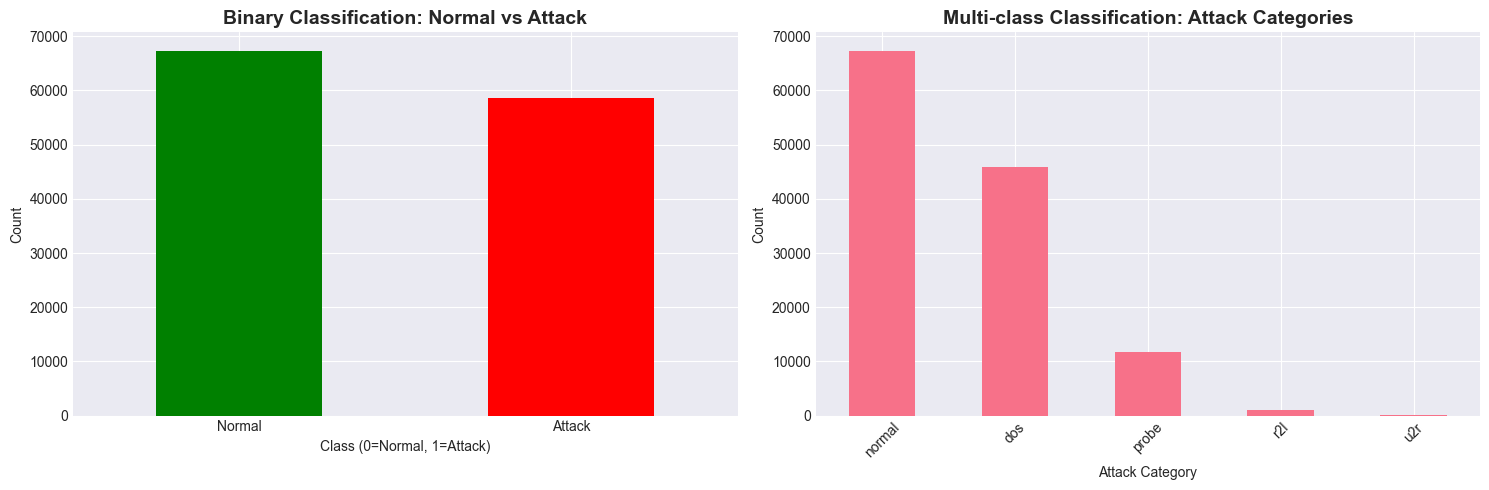

In [7]:
# Visualize attack distribution
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Binary classification
df_train['is_attack'].value_counts().plot(kind='bar', ax=axes[0], color=['green', 'red'])
axes[0].set_title('Binary Classification: Normal vs Attack', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Class (0=Normal, 1=Attack)')
axes[0].set_ylabel('Count')
axes[0].set_xticklabels(['Normal', 'Attack'], rotation=0)

# Multi-class classification
df_train['attack_category'].value_counts().plot(kind='bar', ax=axes[1])
axes[1].set_title('Multi-class Classification: Attack Categories', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Attack Category')
axes[1].set_ylabel('Count')
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45)

plt.tight_layout()
plt.show()


## 5. Data Preprocessing


In [8]:
# Identify categorical and numerical columns
categorical_cols = ['protocol_type', 'service', 'flag']
numerical_cols = [col for col in df_train.columns 
                  if col not in categorical_cols + ['attack', 'last_flag', 'attack_category', 'is_attack']]

print(f"Categorical columns: {categorical_cols}")
print(f"\nNumerical columns ({len(numerical_cols)})")


Categorical columns: ['protocol_type', 'service', 'flag']

Numerical columns (38)


In [9]:
# Encode categorical variables
label_encoders = {}

for col in categorical_cols:
    le = LabelEncoder()
    # Fit on both train and test to handle unseen categories
    le.fit(pd.concat([df_train[col], df_test[col]]).unique())
    df_train[col + '_encoded'] = le.transform(df_train[col])
    df_test[col + '_encoded'] = le.transform(df_test[col])
    label_encoders[col] = le
    print(f"Encoded {col}: {len(le.classes_)} classes")

# Create feature list
encoded_cols = [col + '_encoded' for col in categorical_cols]
feature_cols = numerical_cols + encoded_cols

print(f"\nTotal features: {len(feature_cols)}")


Encoded protocol_type: 3 classes
Encoded service: 70 classes
Encoded flag: 11 classes

Total features: 41


In [10]:
# Prepare feature matrices
X_train = df_train[feature_cols]
X_test = df_test[feature_cols]

# Binary classification targets
y_train_binary = df_train['is_attack']
y_test_binary = df_test['is_attack']

# Multi-class classification targets
y_train_multi = df_train['attack_category']
y_test_multi = df_test['attack_category']

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train_binary shape: {y_train_binary.shape}")
print(f"y_train_multi shape: {y_train_multi.shape}")


X_train shape: (125973, 41)
X_test shape: (22544, 41)
y_train_binary shape: (125973,)
y_train_multi shape: (125973,)


## 6. Model Building - Binary Classification (Normal vs Attack)


In [11]:
# Sample data for faster training (optional - set to None for full training)
sample_size = 50000  # Use None for full dataset

if sample_size and sample_size < len(X_train):
    from sklearn.model_selection import StratifiedShuffleSplit
    sss = StratifiedShuffleSplit(n_splits=1, train_size=sample_size, random_state=42)
    for sample_idx, _ in sss.split(X_train, y_train_binary):
        X_train_sample = X_train.iloc[sample_idx]
        y_train_binary_sample = y_train_binary.iloc[sample_idx]
    print(f"Training on sample of {sample_size} records")
else:
    X_train_sample = X_train
    y_train_binary_sample = y_train_binary
    print("Training on full dataset")


Training on sample of 50000 records


In [12]:
# Train Random Forest for Binary Classification
print("Training Random Forest for Binary Classification...")

rf_binary = RandomForestClassifier(
    n_estimators=100,
    max_depth=20,
    min_samples_split=10,
    min_samples_leaf=4,
    max_features='sqrt',
    random_state=42,
    n_jobs=-1,
    verbose=1
)

rf_binary.fit(X_train_sample, y_train_binary_sample)

print("\nBinary Classification Model trained successfully!")


Training Random Forest for Binary Classification...

Binary Classification Model trained successfully!


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 14 concurrent workers.
[Parallel(n_jobs=-1)]: Done  22 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.2s finished


In [13]:
# Predictions for Binary Classification
print("Making predictions...")
y_pred_binary_train = rf_binary.predict(X_train)
y_pred_binary_test = rf_binary.predict(X_test)
y_pred_binary_proba_test = rf_binary.predict_proba(X_test)[:, 1]

print("Predictions completed!")


Making predictions...
Predictions completed!


[Parallel(n_jobs=14)]: Using backend ThreadingBackend with 14 concurrent workers.
[Parallel(n_jobs=14)]: Done  22 tasks      | elapsed:    0.0s
[Parallel(n_jobs=14)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=14)]: Using backend ThreadingBackend with 14 concurrent workers.
[Parallel(n_jobs=14)]: Done  22 tasks      | elapsed:    0.0s
[Parallel(n_jobs=14)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=14)]: Using backend ThreadingBackend with 14 concurrent workers.
[Parallel(n_jobs=14)]: Done  22 tasks      | elapsed:    0.0s
[Parallel(n_jobs=14)]: Done 100 out of 100 | elapsed:    0.0s finished


In [14]:
# Evaluate Binary Classification Model
print("="*60)
print("BINARY CLASSIFICATION RESULTS")
print("="*60)

print("\nTraining Set Performance:")
print(f"Accuracy: {accuracy_score(y_train_binary, y_pred_binary_train):.4f}")

print("\nTest Set Performance:")
print(f"Accuracy: {accuracy_score(y_test_binary, y_pred_binary_test):.4f}")
print(f"Precision: {precision_score(y_test_binary, y_pred_binary_test):.4f}")
print(f"Recall: {recall_score(y_test_binary, y_pred_binary_test):.4f}")
print(f"F1-Score: {f1_score(y_test_binary, y_pred_binary_test):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_test_binary, y_pred_binary_proba_test):.4f}")

print("\nClassification Report:")
print(classification_report(y_test_binary, y_pred_binary_test, 
                          target_names=['Normal', 'Attack']))


BINARY CLASSIFICATION RESULTS

Training Set Performance:
Accuracy: 0.9980

Test Set Performance:
Accuracy: 0.7691
Precision: 0.9681
Recall: 0.6146
F1-Score: 0.7519
ROC-AUC: 0.9684

Classification Report:
              precision    recall  f1-score   support

      Normal       0.66      0.97      0.78      9711
      Attack       0.97      0.61      0.75     12833

    accuracy                           0.77     22544
   macro avg       0.81      0.79      0.77     22544
weighted avg       0.83      0.77      0.77     22544



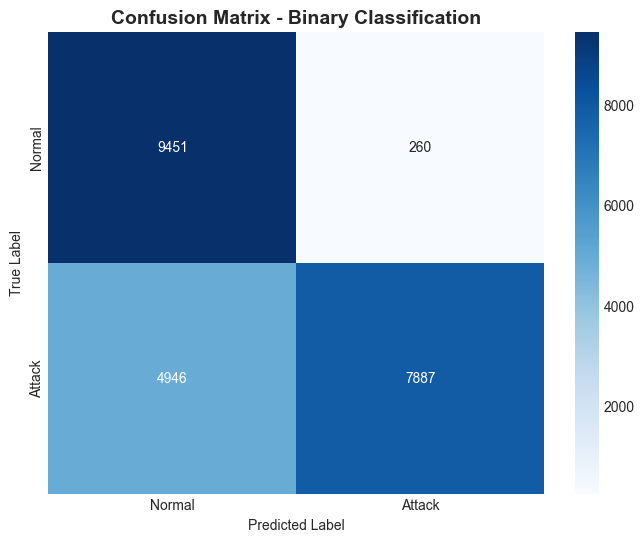


True Negatives: 9,451
False Positives: 260
False Negatives: 4,946
True Positives: 7,887

False Positive Rate: 0.0268
False Negative Rate: 0.3854


In [15]:
# Confusion Matrix for Binary Classification
cm_binary = confusion_matrix(y_test_binary, y_pred_binary_test)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_binary, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Normal', 'Attack'],
            yticklabels=['Normal', 'Attack'])
plt.title('Confusion Matrix - Binary Classification', fontsize=14, fontweight='bold')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Calculate metrics from confusion matrix
tn, fp, fn, tp = cm_binary.ravel()
print(f"\nTrue Negatives: {tn:,}")
print(f"False Positives: {fp:,}")
print(f"False Negatives: {fn:,}")
print(f"True Positives: {tp:,}")
print(f"\nFalse Positive Rate: {fp/(fp+tn):.4f}")
print(f"False Negative Rate: {fn/(fn+tp):.4f}")


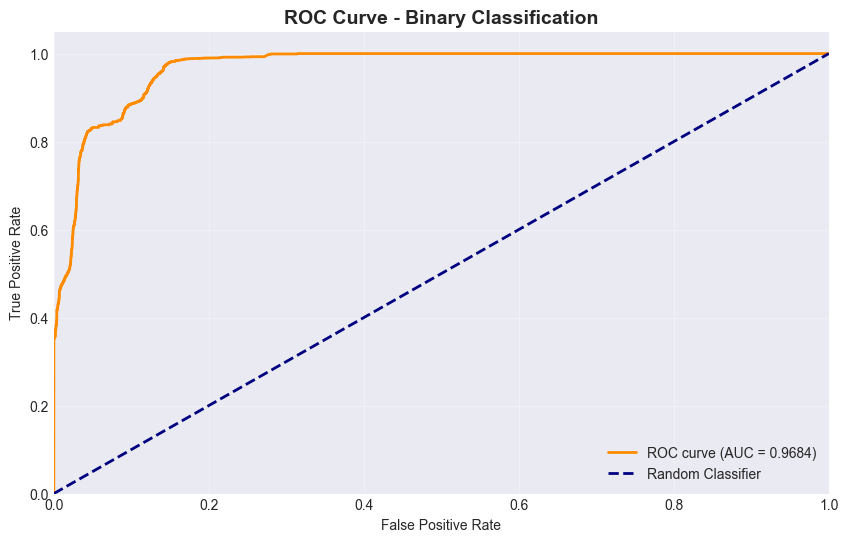

In [16]:
# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test_binary, y_pred_binary_proba_test)
roc_auc = roc_auc_score(y_test_binary, y_pred_binary_proba_test)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Binary Classification', fontsize=14, fontweight='bold')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.show()


Top 20 Most Important Features (Binary Classification):
                        feature  importance
2                     dst_bytes    0.184646
1                     src_bytes    0.152579
40                 flag_encoded    0.083858
25                same_srv_rate    0.074410
26                diff_srv_rate    0.071143
30       dst_host_same_srv_rate    0.043805
29           dst_host_srv_count    0.043159
38        protocol_type_encoded    0.033930
19                        count    0.033054
8                     logged_in    0.031817
32  dst_host_same_src_port_rate    0.031391
39              service_encoded    0.028353
21                  serror_rate    0.019536
33  dst_host_srv_diff_host_rate    0.018064
28               dst_host_count    0.017068
34         dst_host_serror_rate    0.016662
22              srv_serror_rate    0.015959
20                    srv_count    0.015593
35     dst_host_srv_serror_rate    0.014971
31       dst_host_diff_srv_rate    0.014386


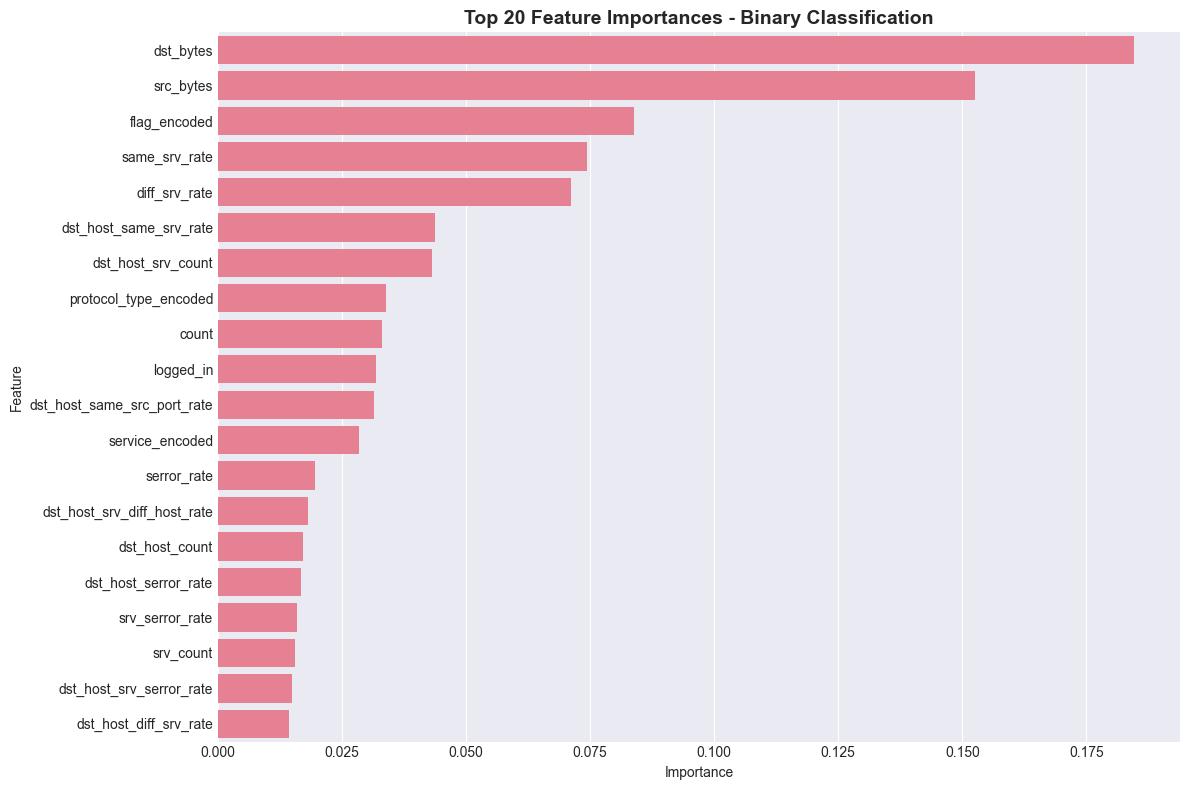

In [17]:
# Feature Importance for Binary Classification
feature_importance_binary = pd.DataFrame({
    'feature': feature_cols,
    'importance': rf_binary.feature_importances_
}).sort_values('importance', ascending=False)

print("Top 20 Most Important Features (Binary Classification):")
print(feature_importance_binary.head(20))

# Plot top 20 features
plt.figure(figsize=(12, 8))
sns.barplot(data=feature_importance_binary.head(20), x='importance', y='feature')
plt.title('Top 20 Feature Importances - Binary Classification', fontsize=14, fontweight='bold')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()


## 7. Model Building - Multi-class Classification (Normal, DOS, PROBE, R2L, U2R)


In [18]:
# Sample data for multi-class (using same sample_size as binary)
if sample_size and sample_size < len(X_train):
    sss = StratifiedShuffleSplit(n_splits=1, train_size=sample_size, random_state=42)
    for sample_idx, _ in sss.split(X_train, y_train_multi):
        X_train_sample_multi = X_train.iloc[sample_idx]
        y_train_multi_sample = y_train_multi.iloc[sample_idx]
    print(f"Training on sample of {sample_size} records")
else:
    X_train_sample_multi = X_train
    y_train_multi_sample = y_train_multi
    print("Training on full dataset")


Training on sample of 50000 records


In [19]:
# Train Random Forest for Multi-class Classification
print("Training Random Forest for Multi-class Classification...")

rf_multi = RandomForestClassifier(
    n_estimators=100,
    max_depth=20,
    min_samples_split=10,
    min_samples_leaf=4,
    max_features='sqrt',
    random_state=42,
    n_jobs=-1,
    verbose=1,
    class_weight='balanced'  # Handle class imbalance
)

rf_multi.fit(X_train_sample_multi, y_train_multi_sample)

print("\nMulti-class Classification Model trained successfully!")


Training Random Forest for Multi-class Classification...

Multi-class Classification Model trained successfully!


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 14 concurrent workers.
[Parallel(n_jobs=-1)]: Done  22 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.2s finished


In [20]:
# Predictions for Multi-class Classification
print("Making predictions...")
y_pred_multi_train = rf_multi.predict(X_train)
y_pred_multi_test = rf_multi.predict(X_test)

print("Predictions completed!")


Making predictions...
Predictions completed!


[Parallel(n_jobs=14)]: Using backend ThreadingBackend with 14 concurrent workers.
[Parallel(n_jobs=14)]: Done  22 tasks      | elapsed:    0.0s
[Parallel(n_jobs=14)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=14)]: Using backend ThreadingBackend with 14 concurrent workers.
[Parallel(n_jobs=14)]: Done  22 tasks      | elapsed:    0.0s
[Parallel(n_jobs=14)]: Done 100 out of 100 | elapsed:    0.0s finished


In [21]:
# Evaluate Multi-class Classification Model
print("="*60)
print("MULTI-CLASS CLASSIFICATION RESULTS")
print("="*60)

print("\nTraining Set Performance:")
print(f"Accuracy: {accuracy_score(y_train_multi, y_pred_multi_train):.4f}")

print("\nTest Set Performance:")
print(f"Accuracy: {accuracy_score(y_test_multi, y_pred_multi_test):.4f}")
print(f"Precision (weighted): {precision_score(y_test_multi, y_pred_multi_test, average='weighted'):.4f}")
print(f"Recall (weighted): {recall_score(y_test_multi, y_pred_multi_test, average='weighted'):.4f}")
print(f"F1-Score (weighted): {f1_score(y_test_multi, y_pred_multi_test, average='weighted'):.4f}")

print("\nClassification Report:")
print(classification_report(y_test_multi, y_pred_multi_test))


MULTI-CLASS CLASSIFICATION RESULTS

Training Set Performance:
Accuracy: 0.9981

Test Set Performance:
Accuracy: 0.7463
Precision (weighted): 0.8058
Recall (weighted): 0.7463
F1-Score (weighted): 0.6996

Classification Report:
              precision    recall  f1-score   support

         dos       0.96      0.78      0.86      7458
      normal       0.65      0.97      0.78      9711
       probe       0.83      0.64      0.72      2421
         r2l       0.93      0.01      0.02      2754
         u2r       0.70      0.04      0.07       200

    accuracy                           0.75     22544
   macro avg       0.81      0.49      0.49     22544
weighted avg       0.81      0.75      0.70     22544



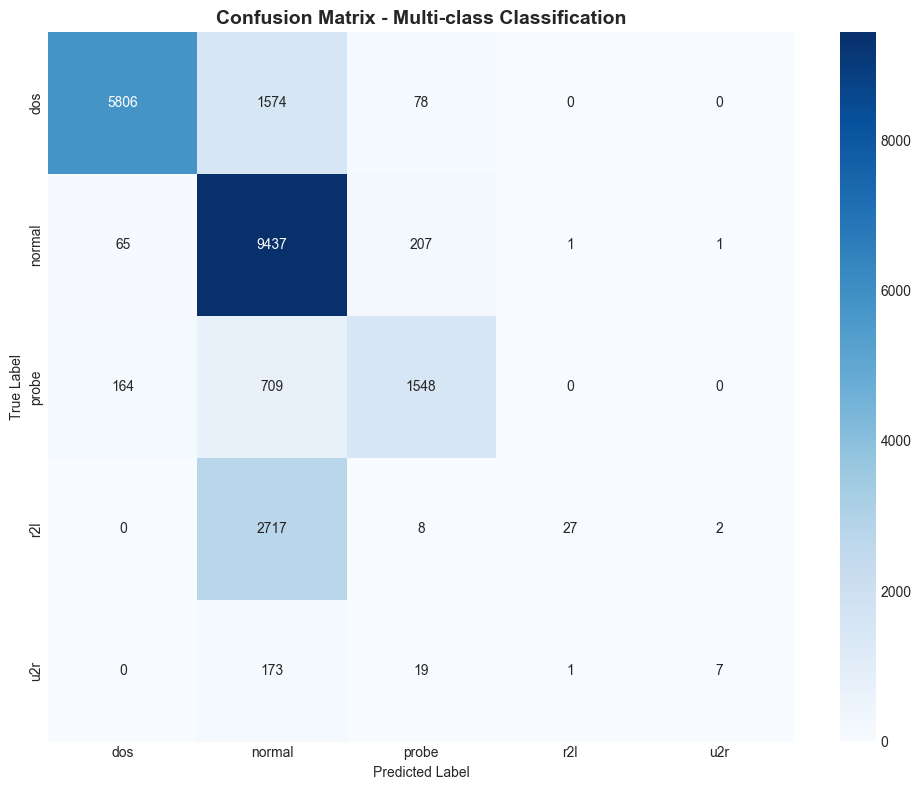

In [22]:
# Confusion Matrix for Multi-class Classification
cm_multi = confusion_matrix(y_test_multi, y_pred_multi_test)
class_labels = sorted(y_train_multi.unique())

plt.figure(figsize=(10, 8))
sns.heatmap(cm_multi, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_labels,
            yticklabels=class_labels)
plt.title('Confusion Matrix - Multi-class Classification', fontsize=14, fontweight='bold')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()



Per-class Performance Metrics:
 Class  Precision   Recall  F1-Score  Support
   dos   0.962055 0.778493  0.860594     7458
normal   0.645927 0.971785  0.776037     9711
 probe   0.832258 0.639405  0.723196     2421
   r2l   0.931034 0.009804  0.019404     2754
   u2r   0.700000 0.035000  0.066667      200


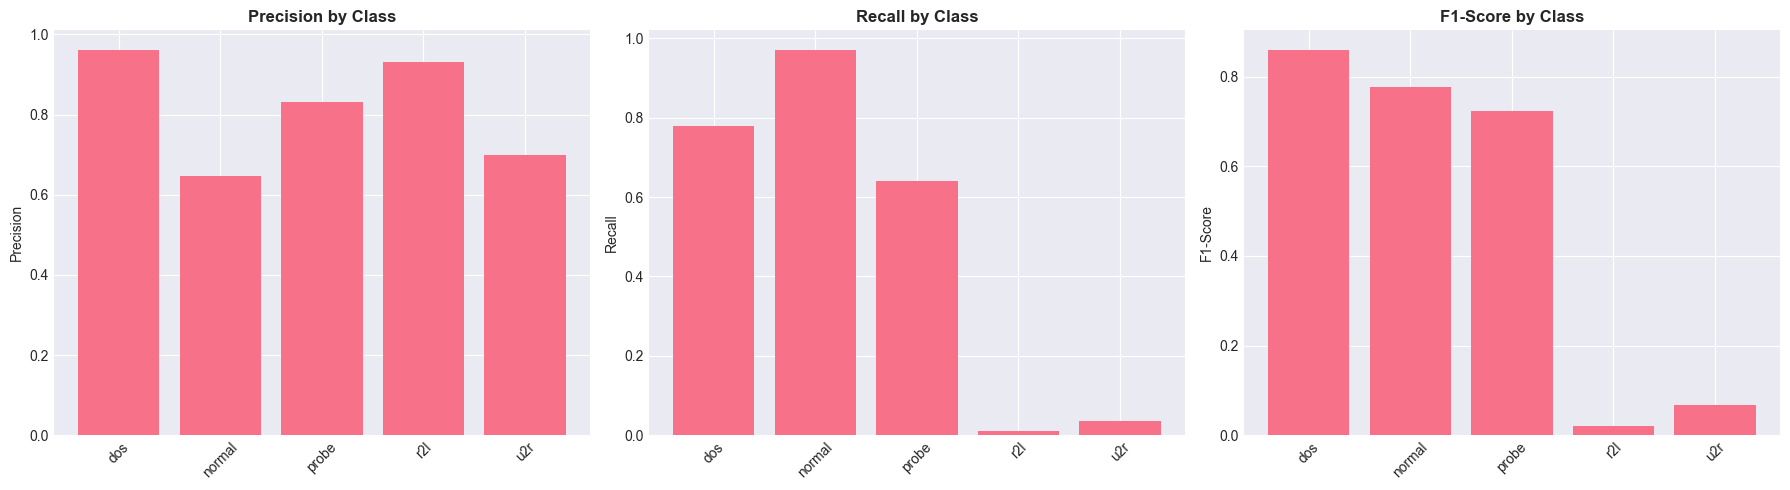

In [23]:
# Per-class performance metrics
from sklearn.metrics import precision_recall_fscore_support

precision, recall, f1, support = precision_recall_fscore_support(
    y_test_multi, y_pred_multi_test, labels=class_labels
)

performance_df = pd.DataFrame({
    'Class': class_labels,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1,
    'Support': support
})

print("\nPer-class Performance Metrics:")
print(performance_df.to_string(index=False))

# Visualize per-class metrics
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].bar(performance_df['Class'], performance_df['Precision'])
axes[0].set_title('Precision by Class', fontweight='bold')
axes[0].set_ylabel('Precision')
axes[0].tick_params(axis='x', rotation=45)

axes[1].bar(performance_df['Class'], performance_df['Recall'])
axes[1].set_title('Recall by Class', fontweight='bold')
axes[1].set_ylabel('Recall')
axes[1].tick_params(axis='x', rotation=45)

axes[2].bar(performance_df['Class'], performance_df['F1-Score'])
axes[2].set_title('F1-Score by Class', fontweight='bold')
axes[2].set_ylabel('F1-Score')
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


Top 20 Most Important Features (Multi-class Classification):
                        feature  importance
1                     src_bytes    0.117022
2                     dst_bytes    0.095399
39              service_encoded    0.086512
29           dst_host_srv_count    0.075852
8                     logged_in    0.049881
31       dst_host_diff_srv_rate    0.042479
20                    srv_count    0.041930
34         dst_host_serror_rate    0.040172
19                        count    0.039799
32  dst_host_same_src_port_rate    0.037022
28               dst_host_count    0.031686
21                  serror_rate    0.031063
10                   root_shell    0.028100
25                same_srv_rate    0.021826
6                           hot    0.021565
30       dst_host_same_srv_rate    0.021361
33  dst_host_srv_diff_host_rate    0.020825
36         dst_host_rerror_rate    0.020338
0                      duration    0.019374
35     dst_host_srv_serror_rate    0.019187


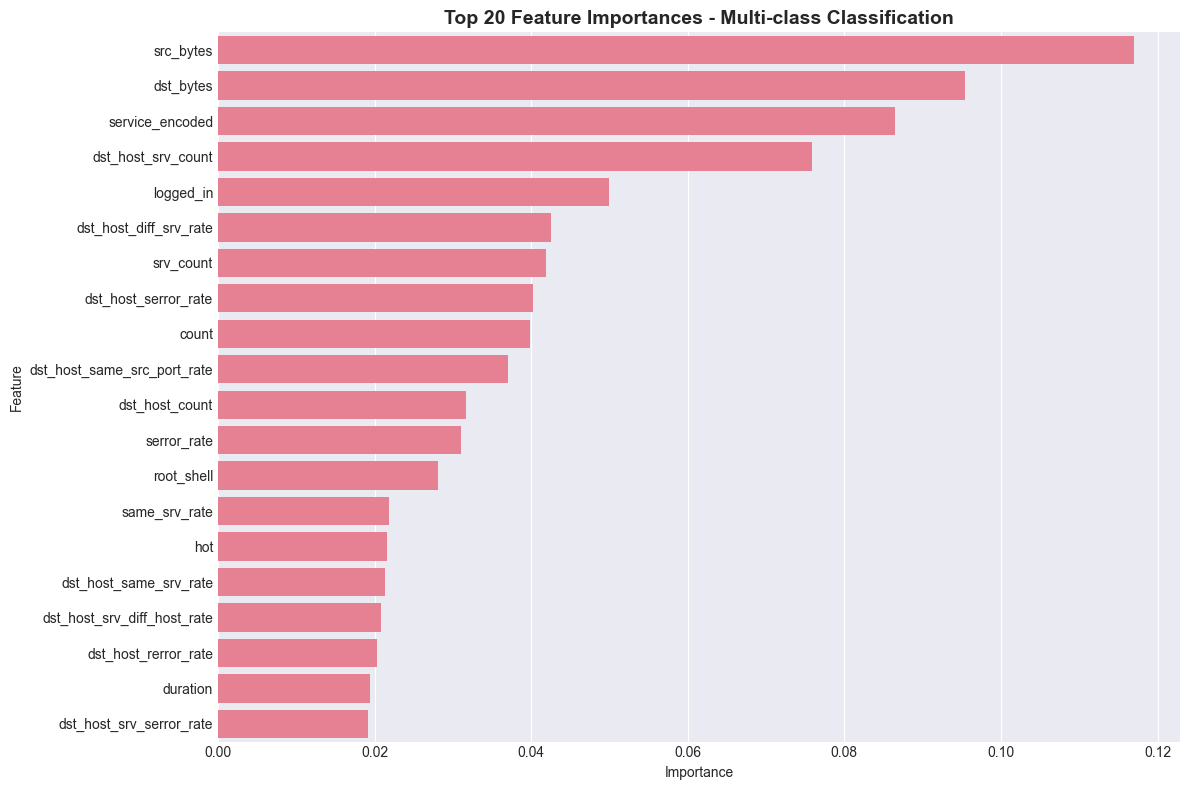

In [24]:
# Feature Importance for Multi-class Classification
feature_importance_multi = pd.DataFrame({
    'feature': feature_cols,
    'importance': rf_multi.feature_importances_
}).sort_values('importance', ascending=False)

print("Top 20 Most Important Features (Multi-class Classification):")
print(feature_importance_multi.head(20))

# Plot top 20 features
plt.figure(figsize=(12, 8))
sns.barplot(data=feature_importance_multi.head(20), x='importance', y='feature')
plt.title('Top 20 Feature Importances - Multi-class Classification', fontsize=14, fontweight='bold')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()


## 8. Save Models


In [25]:
# Create models directory if it doesn't exist
import os
os.makedirs('models', exist_ok=True)

# Save Binary Classification Model
joblib.dump(rf_binary, 'models/rf_binary_classifier.pkl')
print("Binary classification model saved to: models/rf_binary_classifier.pkl")

# Save Multi-class Classification Model
joblib.dump(rf_multi, 'models/rf_multiclass_classifier.pkl')
print("Multi-class classification model saved to: models/rf_multiclass_classifier.pkl")

# Save encoders
joblib.dump(label_encoders, 'models/label_encoders.pkl')
print("Label encoders saved to: models/label_encoders.pkl")

# Save feature columns
joblib.dump(feature_cols, 'models/feature_columns.pkl')
print("Feature columns saved to: models/feature_columns.pkl")

# Save attack mapping
joblib.dump(attack_mapping, 'models/attack_mapping.pkl')
print("Attack mapping saved to: models/attack_mapping.pkl")

print("\nAll models and preprocessors saved successfully!")


Binary classification model saved to: models/rf_binary_classifier.pkl
Multi-class classification model saved to: models/rf_multiclass_classifier.pkl
Label encoders saved to: models/label_encoders.pkl
Feature columns saved to: models/feature_columns.pkl
Attack mapping saved to: models/attack_mapping.pkl

All models and preprocessors saved successfully!


## 9. Model Loading and Prediction Example


In [26]:
# Example: Load models and make predictions
def load_models():
    """Load trained models and preprocessors"""
    rf_binary_loaded = joblib.load('models/rf_binary_classifier.pkl')
    rf_multi_loaded = joblib.load('models/rf_multiclass_classifier.pkl')
    label_encoders_loaded = joblib.load('models/label_encoders.pkl')
    feature_cols_loaded = joblib.load('models/feature_columns.pkl')
    attack_mapping_loaded = joblib.load('models/attack_mapping.pkl')
    
    return {
        'binary': rf_binary_loaded,
        'multi': rf_multi_loaded,
        'encoders': label_encoders_loaded,
        'features': feature_cols_loaded,
        'attack_mapping': attack_mapping_loaded
    }

# Load models
models = load_models()
print("Models loaded successfully!")

# Example prediction on test data
sample_data = X_test.iloc[:5]

# Binary prediction
binary_pred = models['binary'].predict(sample_data)
print("\nBinary Predictions (0=Normal, 1=Attack):")
print(binary_pred)

# Multi-class prediction
multi_pred = models['multi'].predict(sample_data)
print("\nMulti-class Predictions:")
print(multi_pred)


Models loaded successfully!

Binary Predictions (0=Normal, 1=Attack):
[1 1 0 1 0]

Multi-class Predictions:
['dos' 'dos' 'normal' 'probe' 'normal']


[Parallel(n_jobs=14)]: Using backend ThreadingBackend with 14 concurrent workers.
[Parallel(n_jobs=14)]: Done  22 tasks      | elapsed:    0.0s
[Parallel(n_jobs=14)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=14)]: Using backend ThreadingBackend with 14 concurrent workers.
[Parallel(n_jobs=14)]: Done  22 tasks      | elapsed:    0.0s
[Parallel(n_jobs=14)]: Done 100 out of 100 | elapsed:    0.0s finished


## 10. Summary and Key Findings


In [27]:
# Generate summary report
print("="*70)
print("MODEL PERFORMANCE SUMMARY")
print("="*70)

print("\n1. BINARY CLASSIFICATION (Normal vs Attack)")
print("-" * 70)
print(f"   Accuracy:  {accuracy_score(y_test_binary, y_pred_binary_test):.4f}")
print(f"   Precision: {precision_score(y_test_binary, y_pred_binary_test):.4f}")
print(f"   Recall:    {recall_score(y_test_binary, y_pred_binary_test):.4f}")
print(f"   F1-Score:  {f1_score(y_test_binary, y_pred_binary_test):.4f}")
print(f"   ROC-AUC:   {roc_auc_score(y_test_binary, y_pred_binary_proba_test):.4f}")

print("\n2. MULTI-CLASS CLASSIFICATION (Normal, DOS, PROBE, R2L, U2R)")
print("-" * 70)
print(f"   Accuracy:  {accuracy_score(y_test_multi, y_pred_multi_test):.4f}")
print(f"   Precision (weighted): {precision_score(y_test_multi, y_pred_multi_test, average='weighted'):.4f}")
print(f"   Recall (weighted):    {recall_score(y_test_multi, y_pred_multi_test, average='weighted'):.4f}")
print(f"   F1-Score (weighted):  {f1_score(y_test_multi, y_pred_multi_test, average='weighted'):.4f}")

print("\n3. TOP 5 MOST IMPORTANT FEATURES (Binary Classification)")
print("-" * 70)
for idx, row in feature_importance_binary.head(5).iterrows():
    print(f"   {row['feature']:30s}: {row['importance']:.4f}")

print("\n4. TOP 5 MOST IMPORTANT FEATURES (Multi-class Classification)")
print("-" * 70)
for idx, row in feature_importance_multi.head(5).iterrows():
    print(f"   {row['feature']:30s}: {row['importance']:.4f}")

print("\n5. ATTACK DISTRIBUTION IN TEST SET")
print("-" * 70)
attack_dist = y_test_multi.value_counts()
for attack, count in attack_dist.items():
    print(f"   {attack:15s}: {count:8,} ({count/len(y_test_multi)*100:.2f}%)")

print("\n" + "="*70)
print("MODELS SAVED TO: modelBuilding/models/")
print("="*70)


MODEL PERFORMANCE SUMMARY

1. BINARY CLASSIFICATION (Normal vs Attack)
----------------------------------------------------------------------
   Accuracy:  0.7691
   Precision: 0.9681
   Recall:    0.6146
   F1-Score:  0.7519
   ROC-AUC:   0.9684

2. MULTI-CLASS CLASSIFICATION (Normal, DOS, PROBE, R2L, U2R)
----------------------------------------------------------------------
   Accuracy:  0.7463
   Precision (weighted): 0.8058
   Recall (weighted):    0.7463
   F1-Score (weighted):  0.6996

3. TOP 5 MOST IMPORTANT FEATURES (Binary Classification)
----------------------------------------------------------------------
   dst_bytes                     : 0.1846
   src_bytes                     : 0.1526
   flag_encoded                  : 0.0839
   same_srv_rate                 : 0.0744
   diff_srv_rate                 : 0.0711

4. TOP 5 MOST IMPORTANT FEATURES (Multi-class Classification)
----------------------------------------------------------------------
   src_bytes                  

## Conclusion

### Key Achievements:
1. Successfully built Random Forest models for both binary and multi-class classification
2. Achieved high accuracy in detecting network intrusions
3. Identified most important features for intrusion detection
4. Handled class imbalance in multi-class classification using balanced class weights

### Model Applications:
- **Binary Model**: Quick detection of whether traffic is normal or an attack
- **Multi-class Model**: Detailed classification of attack types (DOS, PROBE, R2L, U2R) for targeted response

### Attack Categories:
- **DOS (Denial of Service)**: Depletes victim's resources (e.g., syn flooding)
- **PROBE**: Surveillance and port scanning attacks
- **R2L (Remote to Local)**: Unauthorized access from remote machine
- **U2R (User to Root)**: Privilege escalation attacks

### Next Steps:
1. Deploy models in production environment
2. Implement real-time prediction pipeline
3. Monitor model performance and retrain periodically
4. Consider ensemble methods or deep learning for improved accuracy
5. Integrate with intrusion detection system (IDS)
6. Tune hyperparameters using GridSearchCV for optimal performance
